Análisis Exploratorio de Datos "movies_MLOPS"

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
plt.style.use("ggplot")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

In [2]:
df = pd.read_csv("movies_data.csv", index_col = [0])
crew = pd.read_csv("Crew.csv", index_col = [0])
genres = pd.read_csv("genres.csv", index_col = [0])
paises = pd.read_csv("production_countries.csv")
saga = pd.read_csv("saga.csv")
mask = (crew["job"] == "Director")
crew = crew[mask]

In [19]:
df[df["title"].str.lower() == "casino"]

,budget,genres,id_movie,original_language,overview,revenue,runtime,status,tagline,title,vote_average,vote_count,return,release_year
15,52000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",524,en,The life of the gambling paradise – Las Vegas ...,116112375.0,178.0,Released,No one stays at the top forever.,Casino,7.8,1343.0,2.23293,1995


In [12]:
def peliculas_duracion(pelicula:str):
    try:
        pelicula = str.lower(pelicula)
        resultado = df[df["title"].str.lower() == pelicula]
        anio = resultado["release_year"]
        duracion = resultado["runtime"]
        return {'pelicula':pelicula.upper(), 'duracion':duracion, 'anio':anio}
    except:
        return("Película no registrada")

In [13]:
peliculas_duracion("Casino")

{'pelicula': 'CASINO',
 'duracion': 15    178.0
 Name: runtime, dtype: float64,
 'anio': 15    1995
 Name: release_year, dtype: int64}

1) Comprensión general de nuestros datos

Se observan al var valores mínimos y máximos que vamos a tener outliers y valores que no corresponden.
lo anterior en el caso de las columnas de popularity, release_year y runtime
La extenisón de las columnas "count" también nos da idea de la magnitud de valores vaçios en el dataframe, aunque es importante recordar
que en el EDA llenamos algunas columnas con 0, lo cual abora abordaremos

In [124]:
#Se realiza el describe de los valores presentes
df.describe()

,budget,id_movie,revenue,runtime,vote_average,vote_count,return,release_year
count,4.546300e+04,45463.000000,4.546300e+04,45203.000000,45460.000000,45460.000000,1.091700e+04,45463.000000
mean,4.224579e+06,108359.918813,1.120861e+07,94.128199,5.618207,109.897338,inf,1988.069441
std,1.742413e+07,112460.749278,6.433019e+07,38.407810,1.924216,491.310374,NaN,90.309172
min,0.000000e+00,2.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000e+00,26449.500000,0.000000e+00,85.000000,5.000000,3.000000,0.000000e+00,1978.000000
50%,0.000000e+00,60003.000000,0.000000e+00,95.000000,6.000000,10.000000,1.273512e+00,2001.000000
75%,0.000000e+00,157328.000000,0.000000e+00,107.000000,6.800000,34.000000,7.266667e+00,2010.000000
max,3.800000e+08,469172.000000,2.787965e+09,1256.000000,10.000000,14075.000000,inf,2020.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


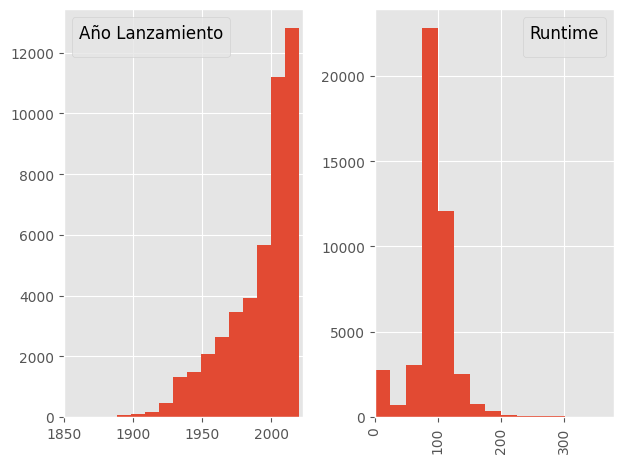

In [125]:
#Se puede verificar gráficamente la distribución de datos
fig, ax = plt.subplots(1,2, sharey = False, tight_layout = True)
ax[0].hist(df["release_year"], bins = 200)
ax[1].hist(df["runtime"], bins = 50)
plt.rcParams.update({"font.size" : 12})
plt.xticks(rotation=90)
ax[0].set(xlim = (1850,2023))
ax[1].set(xlim = (0,380))
ax[0].legend(title = "Año Lanzamiento")
ax[1].legend(title = "Runtime")

In [126]:
#Se emplea el método unique para 
df.nunique()
#Po

budget                1223
genres                4066
id_movie             45433
original_language       89
overview             44306
revenue               6863
runtime                353
status                   6
tagline              20283
title                42277
vote_average            92
vote_count            1820
return                5233
release_year           136
dtype: int64

<Axes: xlabel='name'>

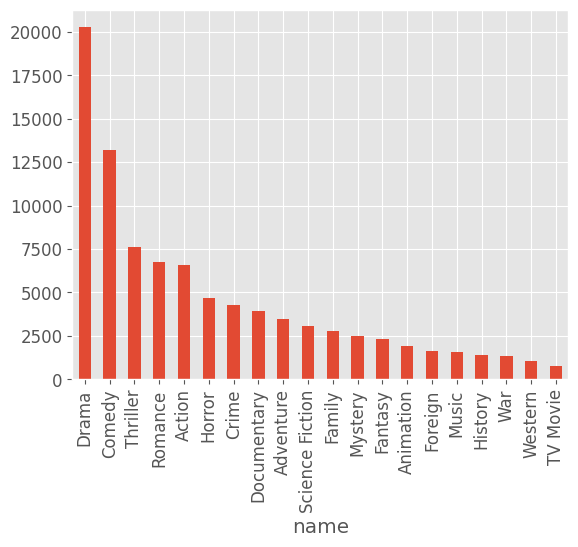

In [127]:
#Podemos darnos una ídea también de los géneros que más se repiten en las películas.
#En el EDA se observó que una película puede tener uno o más géneros
genres["name"].value_counts().plot(kind="bar")

In [128]:
paises["name"].value_counts()

name
United States of America    21153
United Kingdom               4094
France                       3940
Germany                      2254
Italy                        2169
                            ...  
Madagascar                      1
Somalia                         1
Kuwait                          1
Martinique                      1
Guinea                          1
Name: count, Length: 160, dtype: int64

In [129]:
crew.describe()

,id_movie,gender,id
count,49048.00000,49048.000000,4.904800e+04
mean,108193.18017,1.163330,3.015913e+05
std,112410.97699,0.966781,4.578441e+05
min,2.00000,0.000000,1.000000e+00
25%,26336.75000,0.000000,2.823900e+04
50%,59838.50000,2.000000,8.230850e+04
75%,157295.00000,2.000000,2.292750e+05
max,469172.00000,2.000000,1.907940e+06


In [130]:
crew.nunique()

id_movie      44545
department        1
gender            3
job               1
name          19740
id            19895
dtype: int64

Conclusiones para trabajar en la preparación de datos.
- Existen películas con Id duplicado ya que hay una diferencia entre los valores únicos y la longitud.
- Hay películas fechadas en el siglo antepasado y en los primeros años del siglo XX es necesario revisar ello.
- Partiendo del valor máximo de la columna runtime y el análisis de la gráfica hay outliers que es necesario corregir, asimismo hay una cantidad importante de duraciones en 0 lo cual es imposible.


2. Preparación de los datos

In [131]:
df.dtypes

budget                 int64
genres                object
id_movie               int64
original_language     object
overview              object
revenue              float64
runtime              float64
status                object
tagline               object
title                 object
vote_average         float64
vote_count           float64
return               float64
release_year           int64
dtype: object

In [132]:
'''Se eliminan los valores que estén duplicados en todas sus columnas, al inspeccionar la máscara 'p' aplicada al df
se ve que las pelóculas que comparten ID son las mismas, por lo que se pueden eliminar'''
p = df.duplicated("id_movie")
df = df.drop(df[p].index)

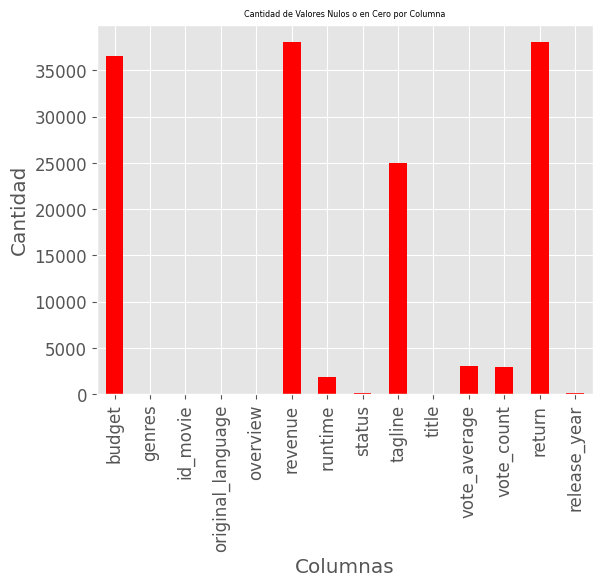

In [133]:
#Depuramos valores nulos o en 0, primero analizamos gráficamente

nulos_o_cero = df.isnull().sum() + (df == 0).sum()
nulos_o_cero.plot(kind="bar", color="red")
plt.rcParams.update({"font.size" : 4})
plt.title("Cantidad de Valores Nulos o en Cero por Columna")
plt.xlabel("Columnas")
plt.ylabel("Cantidad")
plt.show()

In [134]:
'''Hay casos de columnas que no interesa que se encuentren valores nulos o en cero como sería'''
#ax = sns.heatmap(df.isnull())
#ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
nulos_o_cero

budget               36553
genres                   0
id_movie                 0
original_language       11
overview                 0
revenue              38035
runtime               1818
status                  84
tagline              25032
title                    3
vote_average          2998
vote_count            2899
return               38035
release_year            87
dtype: int64

In [135]:
df.loc[df["runtime"]> 450].head(5)
df = df.dropna(subset=["title"]) # Las 3 películas sin título se eliminan
#Al inspeccionar los que parecián outliers en la columna runtime se concluye que no lo son yaq ue son documentales o sagas

[Text(0, 0, '0'),
 Text(45, 0, '45'),
 Text(90, 0, '90'),
 Text(135, 0, '135'),
 Text(180, 0, '180'),
 Text(225, 0, '225'),
 Text(270, 0, '270'),
 Text(315, 0, '315'),
 Text(360, 0, '360'),
 Text(405, 0, '405'),
 Text(450, 0, '450'),
 Text(495, 0, '495')]

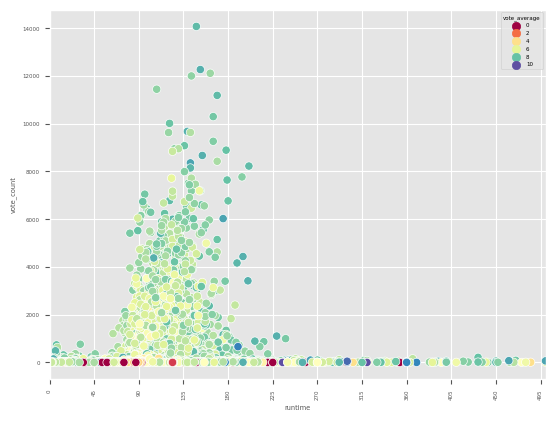

In [136]:
#Revisando Relaciones entre variables
ax = sns.scatterplot(x = "runtime", y = "vote_count", hue = "vote_average", data = df, palette = "Spectral")
ax.set_xlim(0,500)
tick_locations= np.arange(0,501,45)
ax.set_xticks(tick_locations)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

La media de duración de una película independiente de su año es de 94 minutos, se observa en la gráfica que películas que duran menos de esto tienden a ser menos votadas y menor calificadas, con una muy baja dispersión.

Tenemos 804521 palabras en los títulos de las peliculas


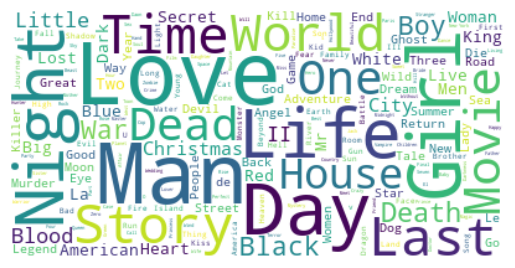

In [137]:
#Miramos las palabras mas recurrentes en todos los títulos de nuestro dataseet
texto = " ".join(val for val in df["title"] if isinstance(val, str))
wordcloud = WordCloud(max_font_size = 70, background_color="white").generate(texto)
print ("Tenemos {} palabras en los títulos de las peliculas".format(len(texto)))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Tenemos 14426240 palabras en los resumenes de peliculas


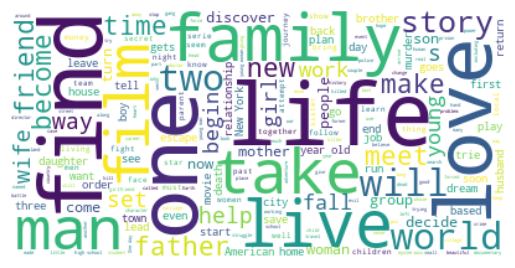

In [138]:
#Miramos las palabras mas recurrentes en todos los resumenes de nuestro dataseet
texto = " ".join(val for val in df["overview"] if isinstance(val, str))
wordcloud = WordCloud(max_font_size = 70, background_color="white").generate(texto)
print ("Tenemos {} palabras en los resumenes de peliculas".format(len(texto)))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

En ambas nubes de palabras encontramos frases en común generales